## Train MLP Models for CDS Index Pricing 

In [111]:
# Library requirements 
import pandas as pd
import numpy as np
import tensorflow as tf
import time 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error , mean_absolute_error

%run mlp_models.ipynb
%run plotting.ipynb


## Config Settings 
Configuration settings for Model, Data and Control;   

-   **Model**:   Controlling which model to train with (or load a saved model)  
-   **Data**:    Specify the training features to use and the target label  
-   **Control**: Specify how to normalise the data, how many training epochs, if subsampling and what metric to use.    


In [96]:
# SAVED MODELS
# model_ss_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)
# model_ms_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)
# model_ls_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)

# model_sl_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all)
# model_ml_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all)
# model_ll_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all) 

# model_flat_(20_20_20_20_1_KIG_E200_1e5_SP)_(r_c_s_smc_t)_logy_(index_contracts_all)  : BEST MODEL 


config = dict(# Model
              model = 'model_flat',           # model version 
              train_or_load = 'load',         # (train, load) 
              model_path ='./saved_models/', 
              model_save_name = '',           # train_or_load == 'train'
              model_load_name = 'model_flat_(20_20_20_20_1_KIG_E200_1e5_SP)_(r_c_s_smc_t)_logy_(index_contracts_all)', # train_or_load == 'load'

              # Data 
              data_path = "./../../data/", 
              data_name = "index_priced.csv",                               # (index_priced.csv, index_priced_dense.csv)
              X = ('recovery', 'coupon', 'spread', 'smc', 'mat_duration'),  # features to train on   
              y = ('mtm',),

              # Control 
              transform_y = 'scale_and_log',     # (scale_only, scale_and_log)
              epochs = 200,
              apply_sampling = True,
              apply_rounding = True,
              y_shift = 0.44,                    # to make all mtm values +ve 
              loss = 'mean_absolute_error'       # (mean_absolute_error, mean_squared_error)
)


## Load and Sample Data  

Load the training data and filter for only what we need for model training. 

In [97]:
# Read the CDS Index contracts 
data = pd.read_csv(config['data_path'] + config['data_name'])
data = data[list(config['X'] + config['y'])]


if config['apply_sampling']:
    # add any subsampling required here ...  
    # ignore contracts which are almost worthless 
    sampled_data = data[data.mtm.abs() > 1e-5].copy()
else:
    sampled_data = data.copy() 

if (config['apply_rounding']):    
    sampled_data.loc[:,['mtm', 'spread', 'smc']] = sampled_data.loc[:,['mtm', 'spread', 'smc']].round(8)


sampled_data


,recovery,coupon,spread,smc,mat_duration,mtm
0,0.3,100,0.000539,-0.009461,10.202778,-0.082710
1,0.3,100,0.001046,-0.008954,10.202778,-0.078002
2,0.3,100,0.001586,-0.008414,10.202778,-0.073028
3,0.3,100,0.002053,-0.007947,10.202778,-0.068755
4,0.3,100,0.002554,-0.007446,10.202778,-0.064198
...,...,...,...,...,...,...
236245,0.2,100,0.033058,0.023058,0.013889,0.000318
236246,0.2,100,0.033561,0.023561,0.013889,0.000325
236247,0.2,100,0.034053,0.024053,0.013889,0.000332
236248,0.2,100,0.034572,0.024572,0.013889,0.000339


## Batch and Transform Data 
Normalise the data features, create a train:test split and batch the data.  

In [106]:
# Scale X always 
X = sampled_data.drop(columns=['mtm'])
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Scale y ?
y_scaled = sampled_data['mtm'].values.reshape(-1, 1)
if config['transform_y'] == 'scale_and_log':
    y_scaled = y_scaled + config['y_shift']  # shift all mtms to be +ve 
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_scaled)
    y_scaled = np.log1p(y_scaled)
    
elif config['transform_y'] == 'scale_only':
    y_scaled = y_scaled + config['y_shift']  # shift all mtms to be +ve 
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)
# Batch the data 
batch_size = 32
# Convert the data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Shuffle and batch the datasets
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

# Print out the shapes to verify
for X_batch, y_batch in train_dataset.take(1):
    print(f'X_batch shape: {X_batch.shape}')
    print(f'y_batch shape: {y_batch.shape}')
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {y_test.shape}')

X_batch shape: (32, 5)
y_batch shape: (32, 1)
X_train shape: (188894, 5)
X_test shape: (47224, 1)


In [105]:
X_train.shape


(188894, 5)

## Build, Compile and Fit the Model (or load saved model) 

In [99]:

if config['train_or_load'] == 'train':
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    model = build_model(config['model'], X_train)    
    model.compile(optimizer=Adam(learning_rate=0.001), loss=config['loss'])
    start_time = time.time()
    history = model.fit(train_dataset, epochs=config['epochs'], validation_data=test_dataset, callbacks=[early_stopping])
    end_time = time.time()
    total_time = end_time - start_time
    model.save(config['model_path'] + config['model_save_name'])
    plot_training_loss(history)
    print(f"Total training time: {total_time:.2f} seconds")

elif config['train_or_load'] == 'load':
    model = load_model(config['model_path'] + config['model_load_name'])

else:
    raise ValueError(f"Unrecognized value for 'train_or_load': {config['train_or_load']}. Expected 'train' or 'load'.")

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FWD_L1 (Dense)              (None, 20)                120       
                                                                 
 FWD_L2 (Dense)              (None, 20)                420       
                                                                 
 FWD_L3 (Dense)              (None, 20)                420       
                                                                 
 FWD_L4 (Dense)              (None, 20)                420       
                                                                 
 y_pred (Dense)              (None, 1)                 21        
                                                                 
Total params: 1401 (5.47 KB)
Trainable params: 1401 (5.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Evaluate the Model  

Evaluate the model on the test set and create a dataframe useful for analysing the distribution and size of relative and absolute accuracy of ground truth vs predicted MtMs.   

1476/1476 [==============================] - 1s 914us/step
Mean Absolute Error on test set: 0.00011570678500835408


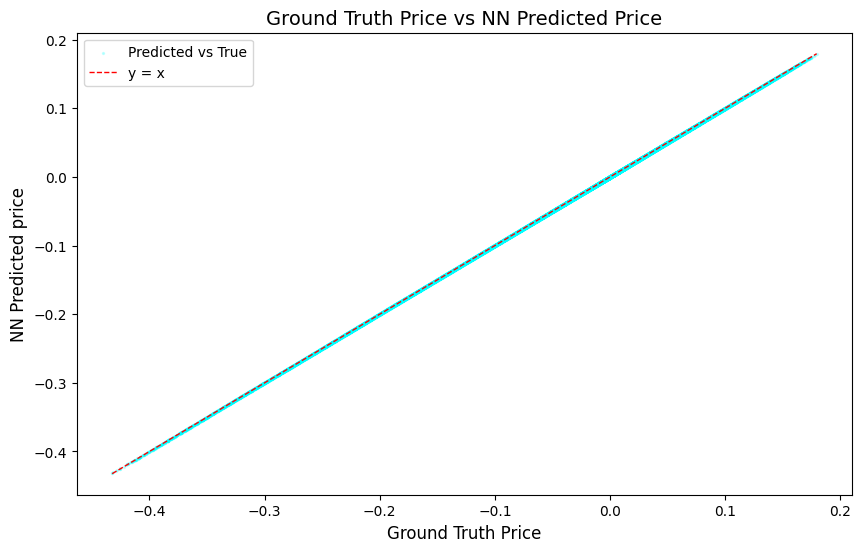

In [113]:

# Evaluate the model
y_pred = model.predict(X_test)

# Reverse any y transformations 
if config['transform_y'] == 'scale_and_log':
    y_pred = np.expm1(y_pred)  # Reverse the log1p transformation
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = y_pred - config['y_shift']
    y_test_ = np.expm1(y_test)
    y_test_ = scaler_y.inverse_transform(y_test_)
    y_test_ = y_test_ - config['y_shift']

elif config['transform_y'] == 'scale_only':
    y_pred = scaler_y.inverse_transform(y_pred)
    y_pred = y_pred - config['y_shift']
    y_test_ = scaler_y.inverse_transform(y_test)
    y_test_ = y_test_ - config['y_shift']

if config['loss'] == 'mean_squared_error':
    mse = mean_squared_error(y_test_, y_pred)
    print(f'Mean Squared Error on test set: {mse}')
elif config['loss'] == 'mean_absolute_error':
    mse = mean_absolute_error(y_test_, y_pred)
    print(f'Mean Absolute Error on test set: {mse}')

# Plot ground truth vs NN predictions on test set 
plot_pred_vs_test(y_test_, y_pred, 'Ground Truth Price vs NN Predicted Price', 'Ground Truth Price', 'NN Predicted price')

# Create a data frame with y_test and y_pred values and the relative and absolute diffs 
df = pd.DataFrame({
    'y_test': y_test_.flatten(),
    'y_pred': y_pred.flatten()
})
df['diff_rel'] = (df['y_test'] - df['y_pred']) / df['y_test'] * 100
df['diff_abs'] = (df['y_test'] - df['y_pred']) 


## Prediction Errors  
Amanlyse the prediction relative and absolute prediction accuracy across MtM bins and uniformly across the entire test set.  

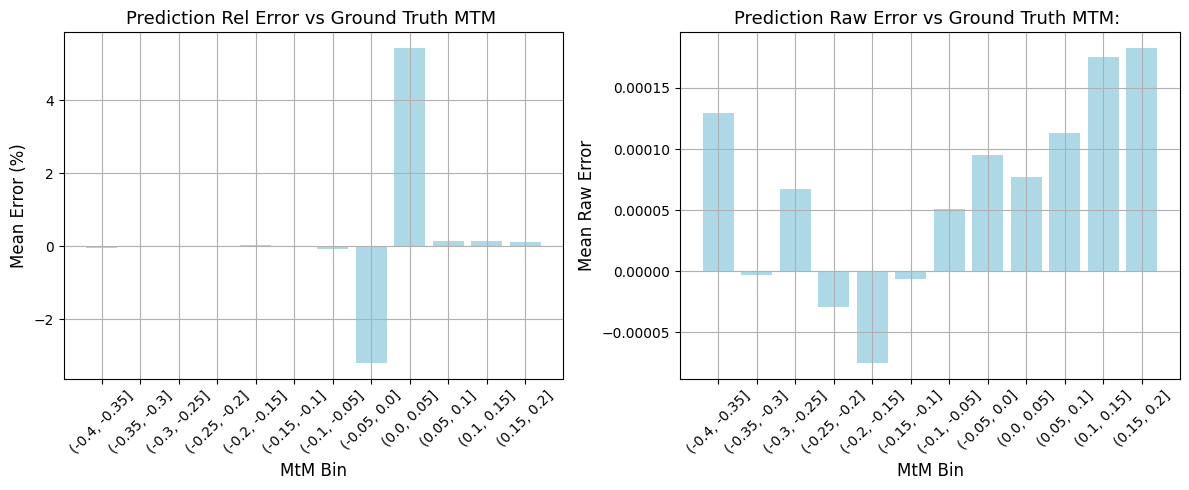

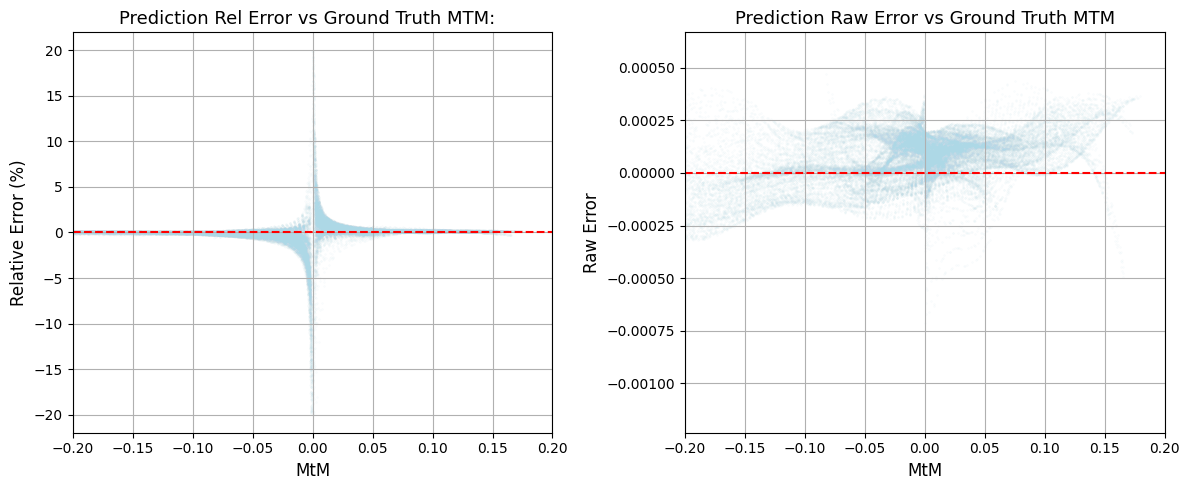

,mtm_bin,diff_rel
0,"(-0.4, -0.35]",-0.034597
1,"(-0.35, -0.3]",0.001074
2,"(-0.3, -0.25]",-0.024970
3,"(-0.25, -0.2]",0.014167
4,"(-0.2, -0.15]",0.042792
5,"(-0.15, -0.1]",0.003765
6,"(-0.1, -0.05]",-0.075785
7,"(-0.05, 0.0]",-3.189809
8,"(0.0, 0.05]",5.433074
9,"(0.05, 0.1]",0.157960


In [110]:
# Mean percentage prediction error across MtM bins 
df_abs = df[df.y_test.abs() > 1e-5]
bin_errors = plot_pred_error_rel_twice(df, df_abs, 'idx', 'Prediction Rel Error vs Ground Truth Price ', 'Prediction Raw Error vs Ground Truth Price: ')

# Relative and absolute prediction errors (no bins) 
df_rel = df[df['diff_rel'].abs() < 20 ]
plot_pred_error_twice(df_rel, df, 'idx', 'Prediction Rel Error vs Ground Truth Price:  ', 'Prediction Raw Error vs Ground Truth Price')
bin_errors[0]

## Calculate Metrics

In [102]:
# Calculate some metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error (MAE): {mae}')

Mean Squared Error (MSE): 0.28133243721059736
Root Mean Squared Error (RMSE): 0.5304078027429436
Mean Absolute Error (MAE): 0.5303150771104483


## NN Model Inference Performance against ISDA Standard Pricer

In [103]:
# Time the inference of the entire training set and compare to the time taken by the Standard ISDA Pricer 
idx_small_isda_time = 326 
idx_large_isda_time = 2670 

start_time = time.time()
y_pred_all = model.predict(X_train)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"All Training Data Inference Time: {elapsed_time:.1f} seconds")
print(f"ISDA Standard Pricer Time: {idx_small_isda_time:.1f} seconds")  # From Julia code execution time
print(f"Speedup = {(X_train.shape[0] / sampled_data.shape[0] * idx_small_isda_time)/ elapsed_time:.1f} x")


5903/5903 [==============================] - 5s 866us/step
All Training Data Inference Time: 6.8 seconds
ISDA Standard Pricer Time: 326.0 seconds
Speedup = 38.1 x


## Model Comparison Table

In [94]:
# model_ss_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)
# model_ms_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)
# model_ls_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_all)

data_small_sample = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'Train Time', 'Model Size', 'X_train Size', 'Inference Time', 'ISDA Time', 'T4 GPU Speed Up x'],
    'Model Small': [0.530, 0.281, 0.530, 466, 204, 188894, 6.5, 261, 261/6.5],
    'Model Medium': [0.531, 0.282, 0.531, 463, 204, 188894, 6.6, 261, 261/6.6],
    'Model Large': [0.530, 0.280, 0.530, 396, 274, 188894, 7.0, 261, 261/7.0]
}

df_small = pd.DataFrame(data_small_sample)
df_small = df_small.round({'Model Small': 3, 'Model Medium': 3, 'Model Large':3})
df_small

# model_sl_(32_16_8_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all)
# model_ml_(64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all)
# model_ll_(128_64_32_16_1_BN_KI_E200_1e5)_(r_c_s_smc_t)_logy_(index_contracts_dense_all)

data_large_sample = {
    'Metric': ['MAE', 'MSE', 'RMSE', 'Train Time', 'Model # Parameters', 'X_train Size', 'T4 GPU Inference Time', 'ISDA Pricer Time', 'Speed Up x'],
    'Model Small (32:16:8:1)': [0.531, 0.282, 0.531, 3099, 1057, 1870636, 6.4, 2135, 2135/6.4],
    'Model Medium (64:32:16:1)': [0.530, 0.281, 0.530, 3343, 3393, 1870636, 5.3, 2135, 2135/5.3],
    'Model Large (128:64:32:16:1)': [0.529, 0.281, 0.530, 3248, 12545, 1870636, 5.1, 2135, 2135/5.1],
    'Model Flat (20:20:20:20:1)': [0.529, 0.280, 0.529, 3250, 1401, 1870636, 5.1, 2135, 2135/5.1]
}


df_large = pd.DataFrame(data_large_sample)
df_large = df_large.round({'Model Small (32:16:8:1)': 3, 'Model Medium (64:32:16:1)': 3, 'Model Large (128:64:32:16:1)':3, 'Model Flat (20:20:20:20:1)':3})
df_large





,Metric,Model Small (32:16:8:1),Model Medium (64:32:16:1),Model Large (128:64:32:16:1),Model Flat (20:20:20:20:1)
0,MAE,0.531,0.530,0.529,0.529
1,MSE,0.282,0.281,0.281,0.280
2,RMSE,0.531,0.530,0.530,0.529
3,Train Time,3099.000,3343.000,3248.000,3250.000
4,Model # Parameters,1057.000,3393.000,12545.000,1401.000
5,X_train Size,1870636.000,1870636.000,1870636.000,1870636.000
6,T4 GPU Inference Time,6.400,5.300,5.100,5.100
7,ISDA Pricer Time,2135.000,2135.000,2135.000,2135.000
8,Speed Up x,333.594,402.830,418.627,418.627
